In [11]:
import gymnasium as gym
import numpy as np
import cv2
import matplotlib.pyplot as plt

(96, 96)


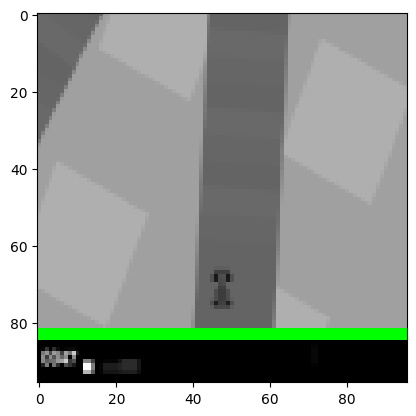

In [70]:
env = gym.make("CarRacing-v3",max_episode_steps=1)  # 'rgb_array' for image-only
obs = env.reset()[0]

for _ in range(70):
    action = np.array([0.0, 1.0, 0.0])
    obs, reward, done, truncated, info = env.step(action)

# Converting to grayscale
img = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
# img_bgr = cv2.cvtColor(obs,cv2.COLOR_BGR2GRAY)

# Applying Canny edge detection
edges = cv2.Canny(img,threshold1=10,threshold2=100)

# print(img.shape)

print(edges.shape)

height,width = edges.shape

mask = np.zeros_like(edges)

mask[int(height/2):,:] = 255

# lower half
roi_edges = cv2.bitwise_and(edges,mask)

# find lines
lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, threshold=50, minLineLength=10, maxLineGap=20)
line_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.imshow(line_img)
plt.show()


# plt.figure(figsize=(10, 10)) 

# plt.subplot(1, 2, 1)
# plt.title("Original")
# plt.imshow(obs)

# plt.subplot(1, 2, 2)
# plt.title("Modified")
# plt.imshow(roi_edges, cmap='gray')

# plt.show()


In [ ]:
for _ in range(1000):
    env.render()
    # Simple action: [steering, gas, brake]
    action = np.array([0.0, 1.0, 0.0])  # go straight with gas
    obs, reward, done, truncated, info = env.step(action)

    if done or truncated:
        break

In [ ]:
env.close()

In [10]:
import pygame
import numpy as np

# Initialize environment
env = gym.make('CarRacing-v3', render_mode='human')
obs = env.reset()[0]

# Initialize pygame for key handling
pygame.init()
# pygame.display.set_mode((1200, 1200))  # Dummy window for key input

# Control mapping
action = np.array([0.0, 0.0, 0.0])  # [steer, gas, brake]

def get_keys():
    keys = pygame.key.get_pressed()
    action = np.array([0.0, 0.0, 0.0])
    if keys[pygame.K_w]:
        action[1] = 1.0  # gas
    if keys[pygame.K_s]:
        action[2] = 0.8  # brake
    if keys[pygame.K_a]:
        action[0] = -1.0  # steer left
    if keys[pygame.K_d]:
        action[0] = 1.0   # steer right
    return action

clock = pygame.time.Clock()

done = False
while not done:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True

    action = get_keys()
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        done = True

    clock.tick(60)  # Limit to 60 FPS

env.close()
pygame.quit()


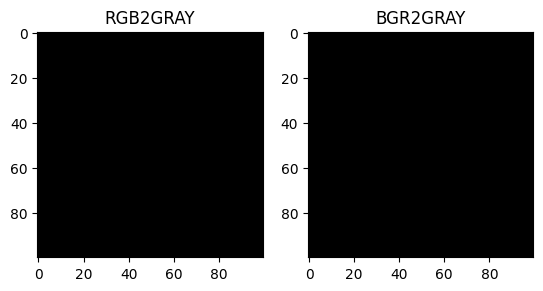

In [39]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Create a pure red image in RGB
rgb_red = np.zeros((100, 100, 3), dtype=np.uint8)
rgb_red[:, :, 0] = 255  # Red channel only

# Convert using both methods
gray_from_rgb = cv2.cvtColor(rgb_red, cv2.COLOR_RGB2GRAY)
gray_from_bgr = cv2.cvtColor(rgb_red, cv2.COLOR_BGR2GRAY)

plt.subplot(1, 2, 1)
plt.title("RGB2GRAY")
plt.imshow(gray_from_rgb, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("BGR2GRAY")
plt.imshow(gray_from_bgr, cmap='gray')

plt.show()


In [72]:
import gymnasium as gym
import cv2
import numpy as np

# ---- Setup ----
env = gym.make("CarRacing-v3", render_mode="rgb_array")
obs = env.reset()[0]

step = 0
done = False

def resize(img, size=(128, 96)):
    return cv2.resize(img, size)

# ---- Main loop ----
while not done and step < 500:
    # --- Preprocessing ---
    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)

    # Region of Interest (bottom half)
    roi_mask = np.zeros_like(edges)
    roi_mask[edges.shape[0] // 2:, :] = 255
    roi = cv2.bitwise_and(edges, roi_mask)

    # Hough Line Detection
    line_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    lines = cv2.HoughLinesP(roi, 1, np.pi / 180, threshold=50, minLineLength=10, maxLineGap=20)

    road_center_x = obs.shape[1] // 2  # Default center

    if lines is not None:
        centers = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            mid_x = (x1 + x2) // 2
            centers.append(mid_x)
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        road_center_x = int(np.mean(centers))

    # --- Steering Logic ---
    image_center_x = obs.shape[1] // 2
    offset = road_center_x - image_center_x
    max_offset = image_center_x
    steer = np.clip(offset / max_offset, -1.0, 1.0)

    # Action: [steer, gas, brake]
    action = np.array([steer, 1.0, 0.0])
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # --- OpenCV Visualization ---
    gray_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    roi_bgr = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)

    stacked = np.hstack([
        resize(obs),
        resize(gray_bgr),
        resize(roi_bgr),
        resize(line_img)
    ])

    cv2.putText(stacked, f"Step: {step} | Steering: {steer:.2f}", 
                (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    cv2.imshow("CarRacing Vision Pipeline", stacked)

    # Press ESC to quit early
    if cv2.waitKey(1) & 0xFF == 27:
        break

    step += 1

# ---- Cleanup ----
env.close()
cv2.destroyAllWindows()
